In [156]:
import os
import sys
import polars as pl
import polars.selectors as cs

from datetime import datetime

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY
from utils.config_files import load_json_config

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

# load files
config = load_json_config("config.json")

In [157]:
def plot_site_diurnal_patterns(site: str):
    """Plot diurnal patterns of CO₂ for a given site."""
    df = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                        deployment_times=deployment_times,
                                        site_name=site)
    # add datetime information
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    winter = list(range(355, 367)) + list(range(0, 80))

    df = df.with_columns(
        pl.col("datetime")
        .dt.convert_time_zone("Europe/Berlin")
        .alias("datetime_local")) \
        .with_columns(pl.col("datetime_local").dt.ordinal_day().alias("day_of_year"),
                        pl.col("datetime_local").dt.weekday().alias("day_of_week"),
                        pl.col("datetime_local").dt.hour().alias("hour_of_day")) \
        .with_columns(
            pl.when(pl.col("day_of_year").is_in(spring)).then(pl.lit("spring"))
            .when(pl.col("day_of_year").is_in(summer)).then(pl.lit("summer"))
            .when(pl.col("day_of_year").is_in(fall)).then(pl.lit("fall"))
            .when(pl.col("day_of_year").is_in(winter)).then(pl.lit("winter"))
            .otherwise(None)
            .alias("season")
        ).sort("hour_of_day")

    df_summer = df.filter(pl.col("season") == "summer").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_summer"))

    df_fall = df.filter(pl.col("season") == "fall").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_fall"))

    df_winter = df.filter(pl.col("season") == "winter").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_winter"))

    df_spring = df.filter(pl.col("season") == "spring").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_spring"))
        
    y_summer = df_summer["mean_co2_summer"].to_numpy()
    y_fall = df_fall["mean_co2_fall"].to_numpy()
    y_winter = df_winter["mean_co2_winter"].to_numpy()
    y_spring = df_spring["mean_co2_spring"].to_numpy()

    plt.figure(figsize=(12, 5))

    if len(y_spring) > 0:
        x_values = df_spring["hour_of_day"].to_numpy()
        plt.plot(x_values, y_spring, label="Spring", alpha=0.7, linewidth=1)
    if len(y_summer) > 0:
        x_values = df_summer["hour_of_day"].to_numpy()
        plt.plot(x_values, y_summer, label="Summer", alpha=0.7, linewidth=1)
    if len(y_fall) > 0:
        x_values = df_fall["hour_of_day"].to_numpy()
        plt.plot(x_values, y_fall, label="Fall", alpha=0.7, linewidth=1)
    if len(y_winter) > 0:
        x_values = df_winter["hour_of_day"].to_numpy()
        plt.plot(x_values, y_winter, label="Winter", alpha=0.7, linewidth=1)

    plt.xlabel("Hour of Day (Local Time: CET/CEST)")
    plt.ylabel("Mean CO₂ (ppm)")
    plt.title(f"{site}: Diurnal CO₂ Patterns by Season")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

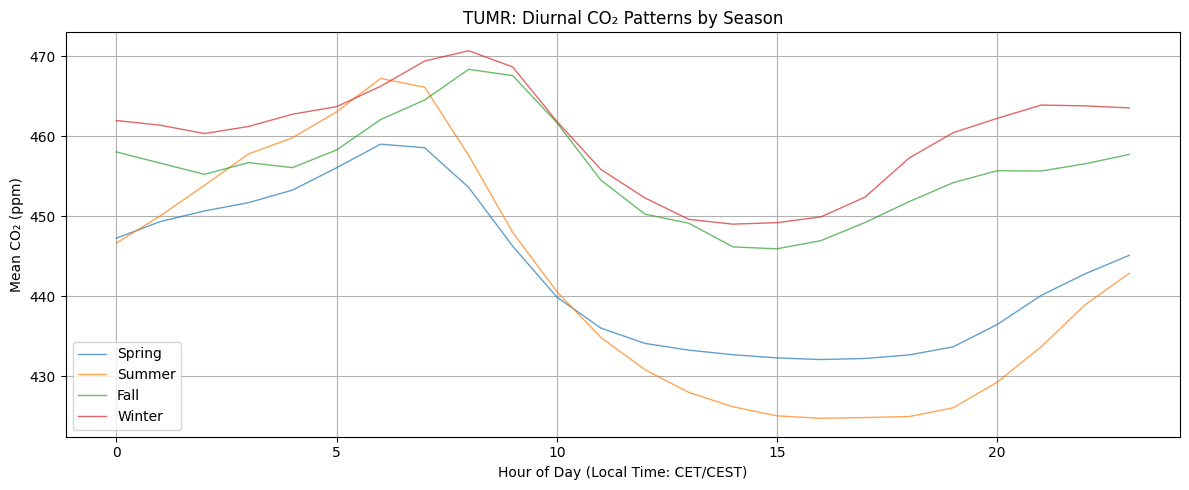

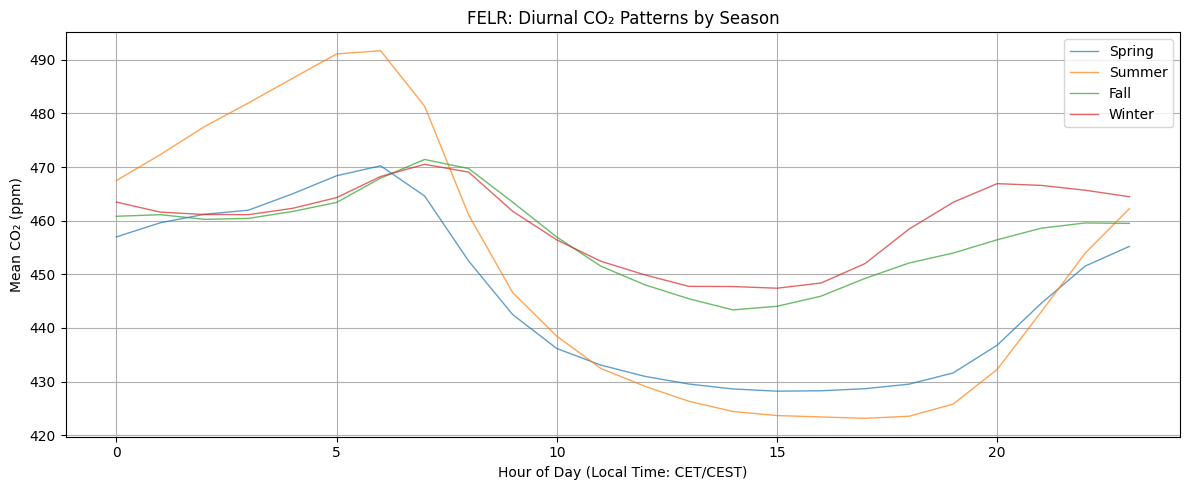

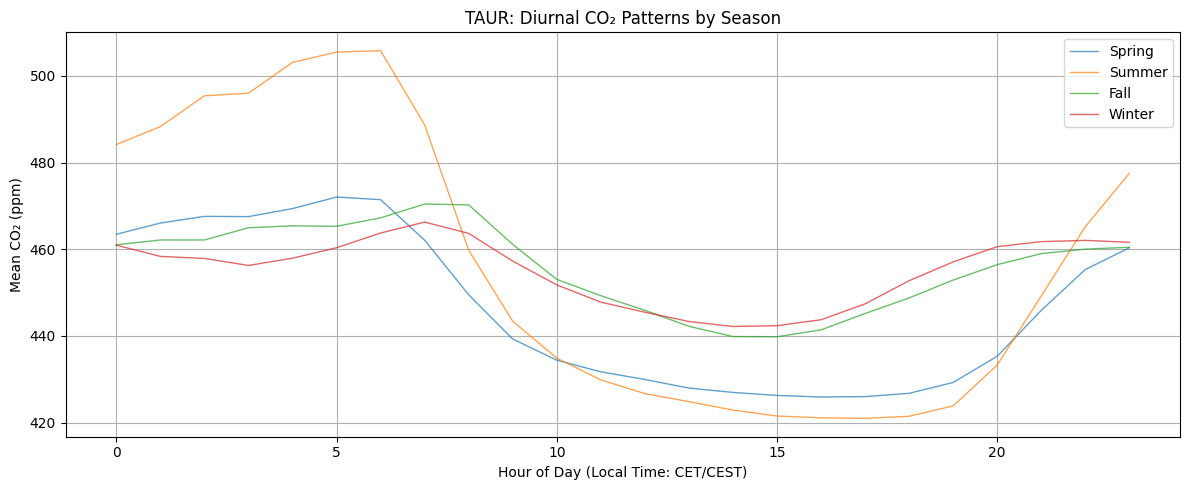

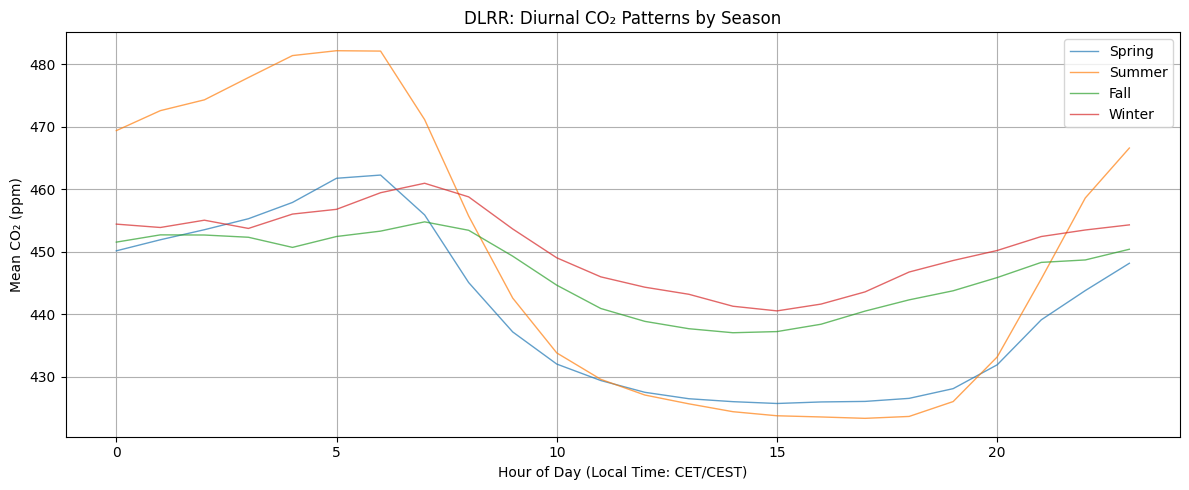

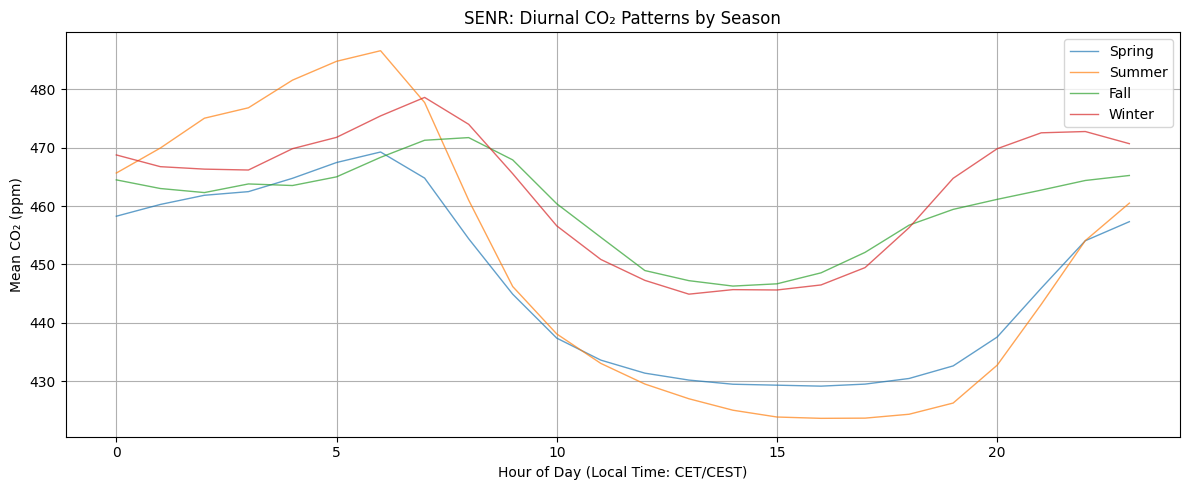

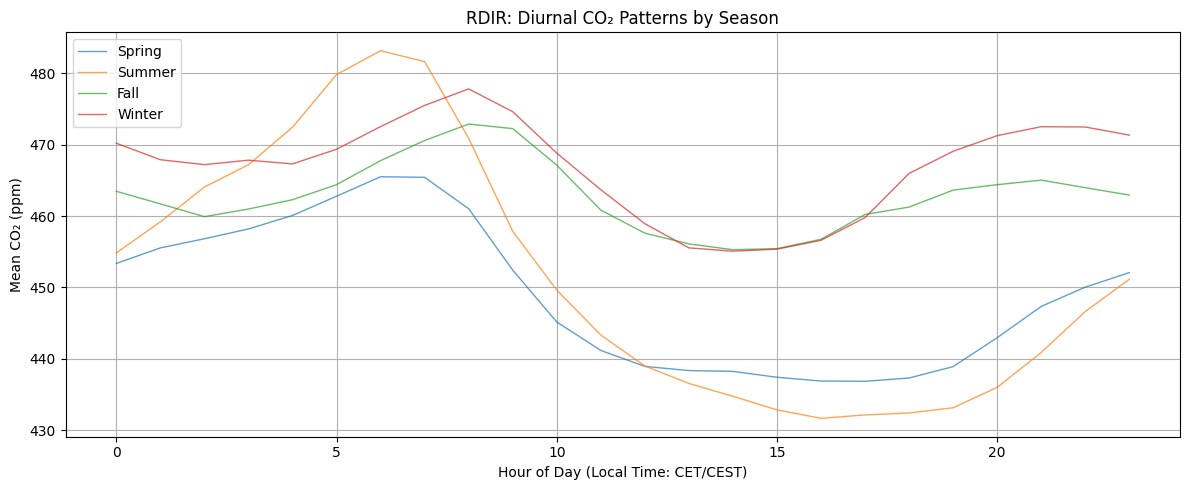

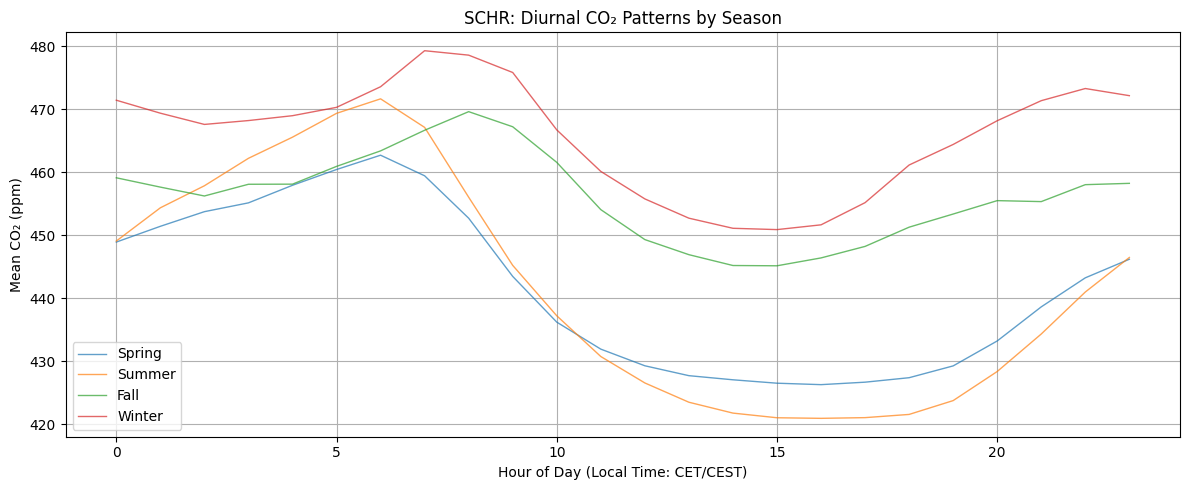

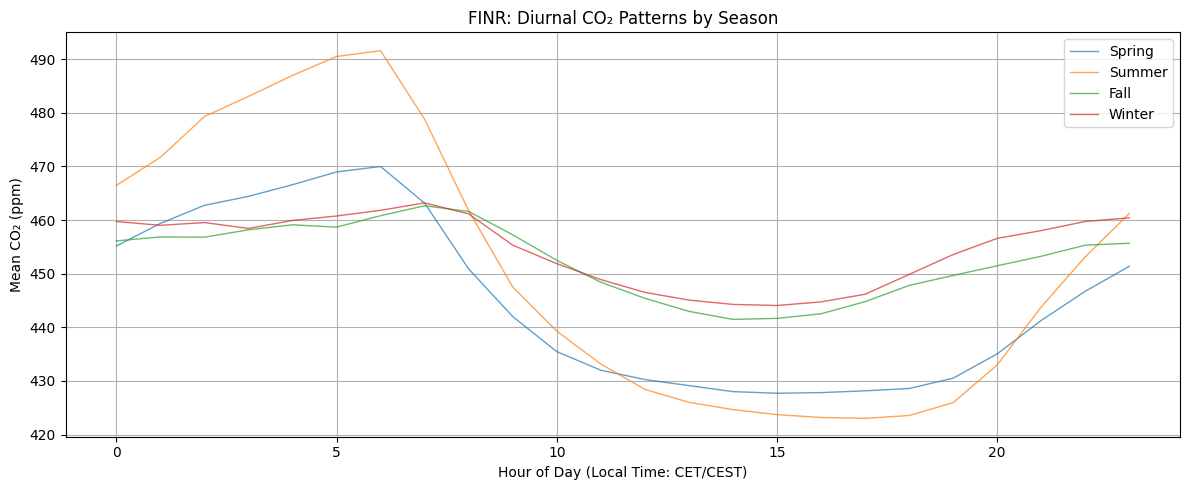

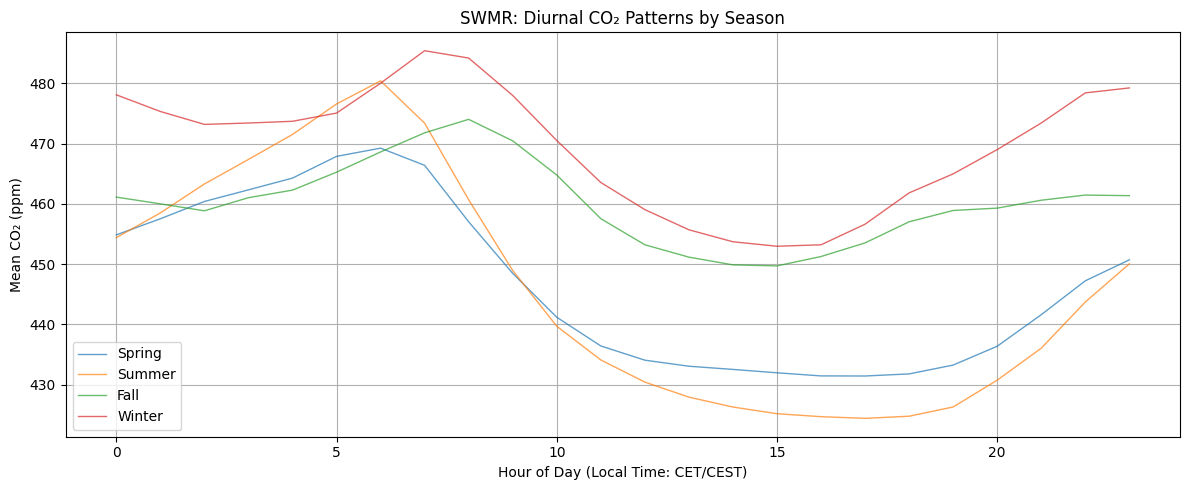

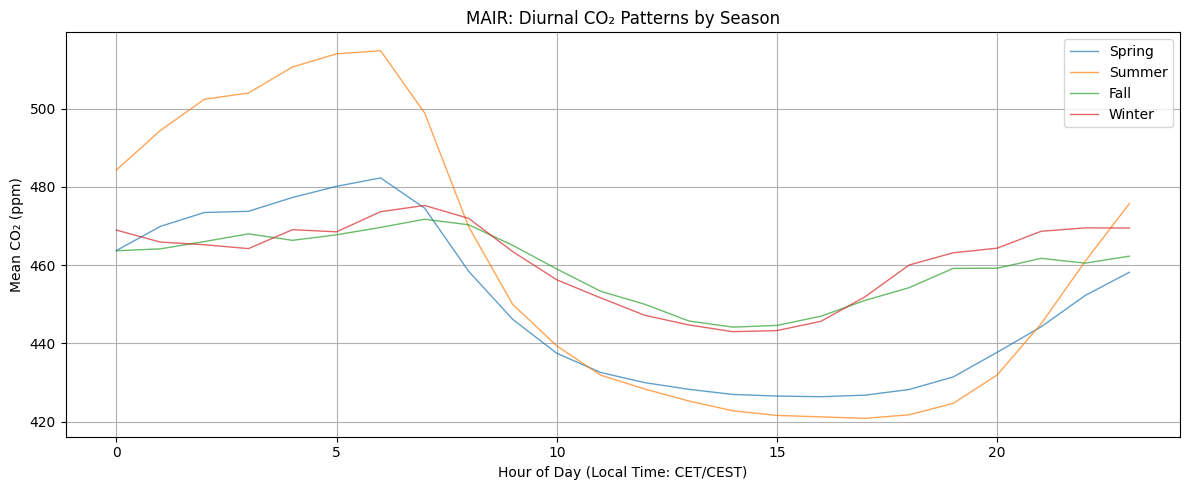

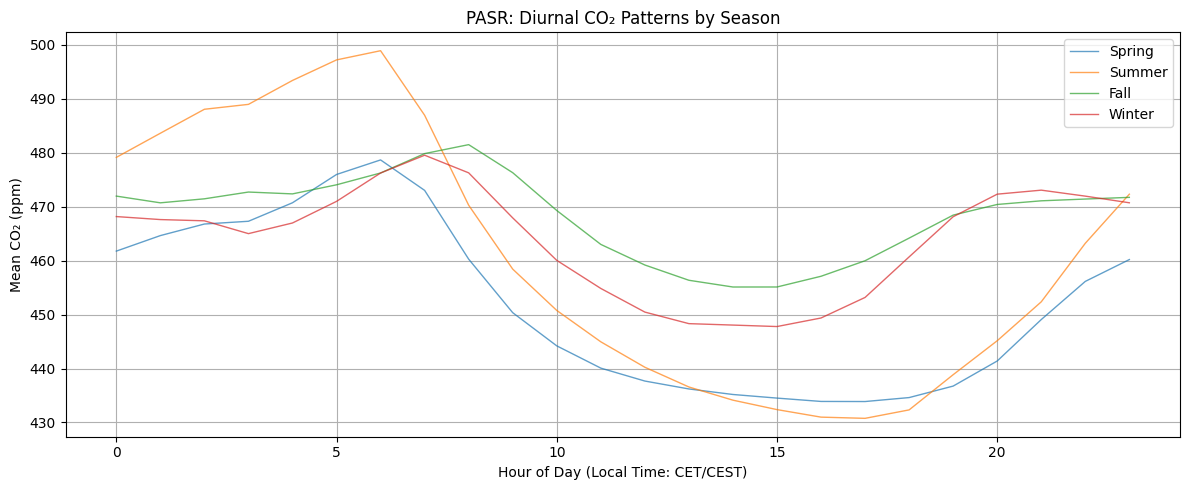

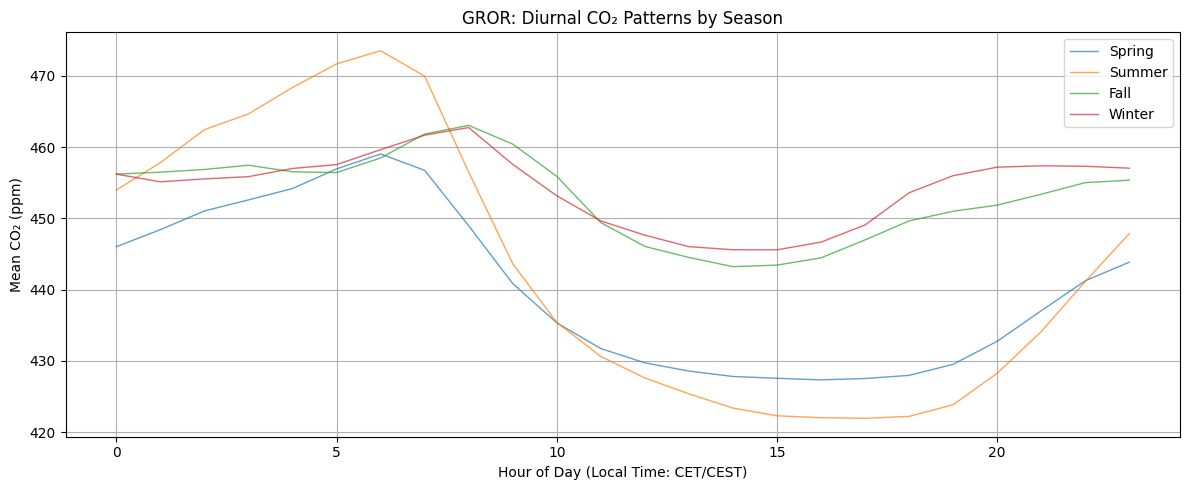

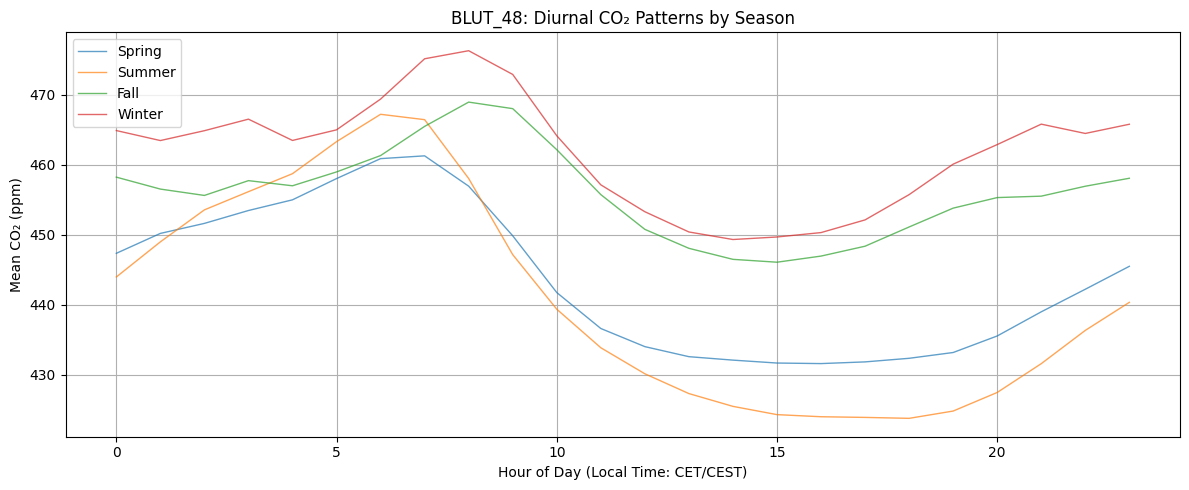

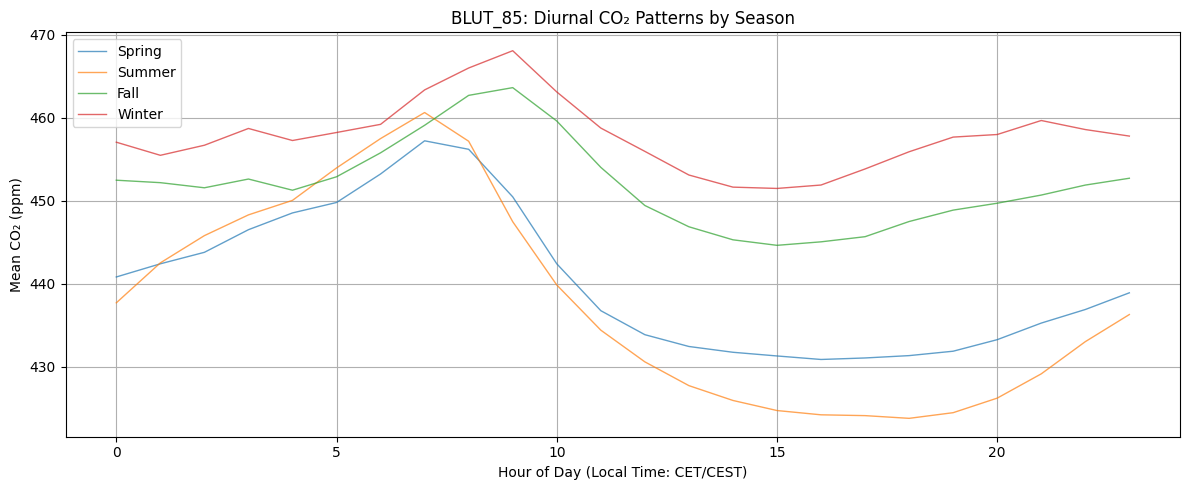

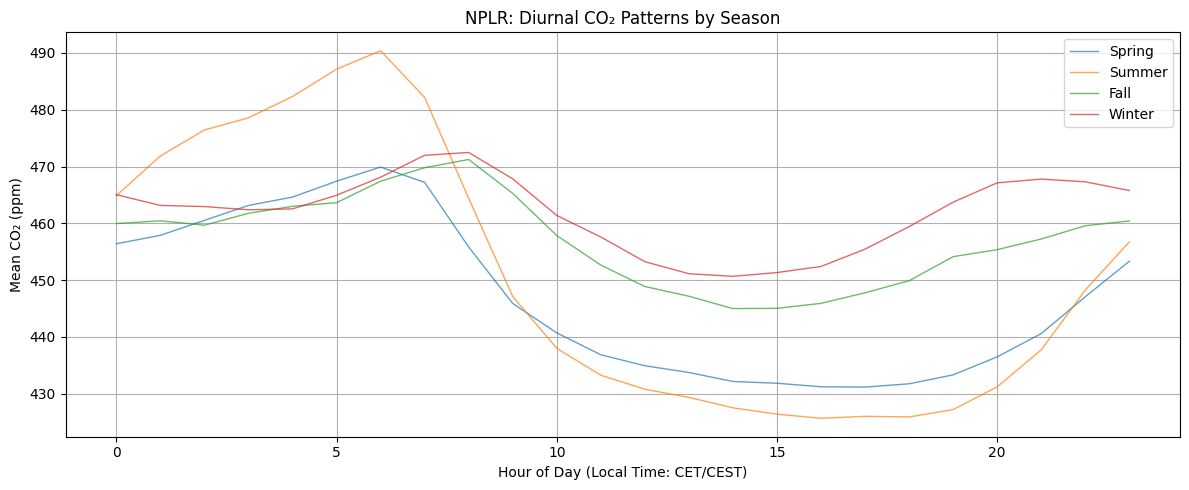

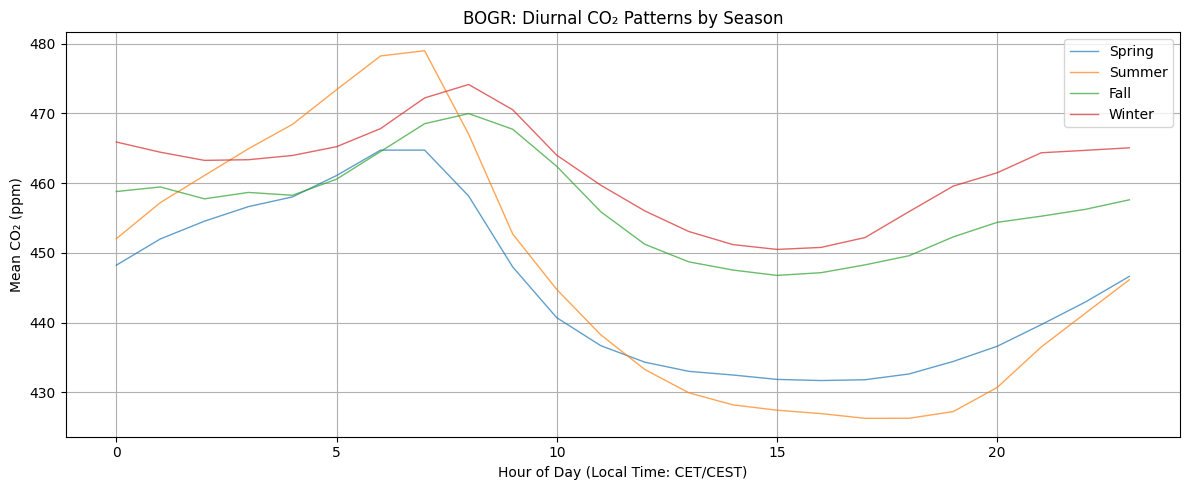

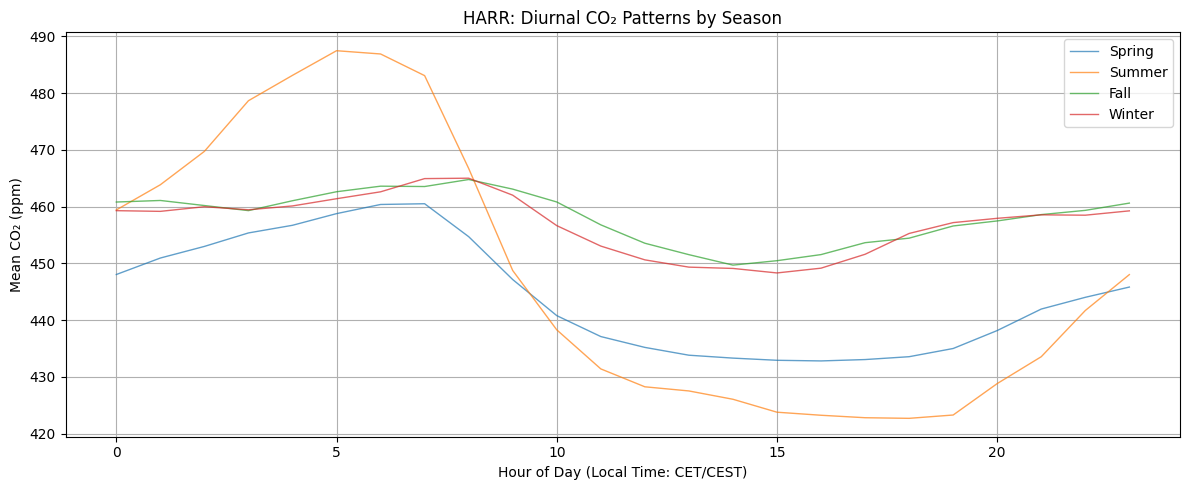

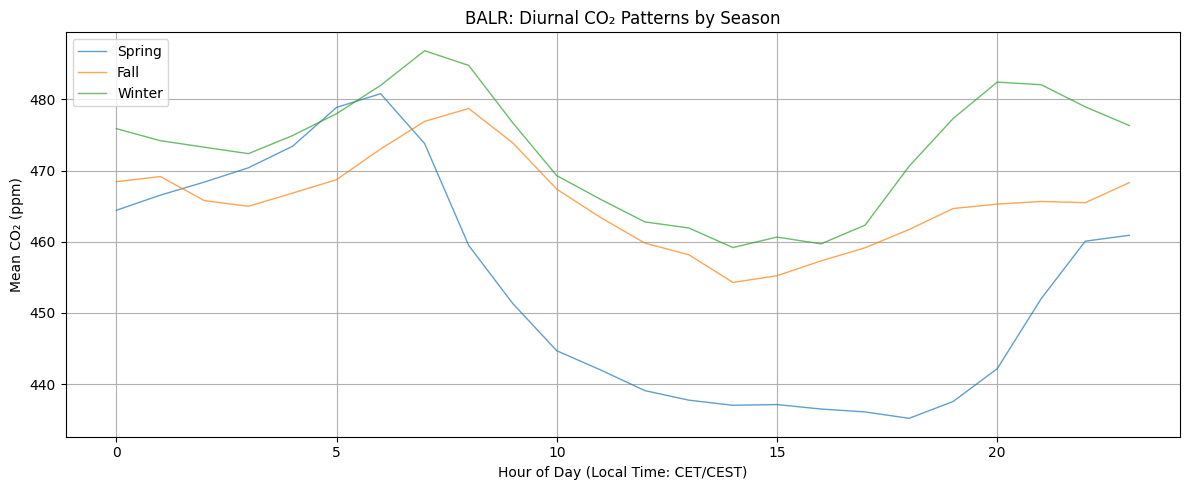

In [158]:
for site in config["icos_cities_portal"]["site_names"]:
    plot_site_diurnal_patterns(site)